In [1]:
import pandas as pd

# Load datasets
diabetes = pd.read_csv("../data/diabetes.csv")
heart = pd.read_csv("../data/heart_disease_uci.csv")

print("Diabetes dataset shape:", diabetes.shape)
print("Heart dataset shape:", heart.shape)

# Quick look
print("\n--- Diabetes dataset ---")
print(diabetes.head())
print(diabetes.info())

print("\n--- Heart dataset ---")
print(heart.head())
print(heart.info())

# Check missing values
print("\nMissing values (diabetes):\n", diabetes.isnull().sum())
print("\nMissing values (heart):\n", heart.isnull().sum())


Diabetes dataset shape: (768, 9)
Heart dataset shape: (920, 16)

--- Diabetes dataset ---
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  

# Data Cleaning

In [5]:
import numpy as np

# ----- Diabetes Cleaning -----
# Replace 0 with NaN in medical columns
diabetes_clean = diabetes.copy()
cols_with_invalid_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
diabetes_clean[cols_with_invalid_zeros] = diabetes_clean[cols_with_invalid_zeros].replace(0, np.nan)

print("Missing values after fixing diabetes dataset:\n", diabetes_clean.isnull().sum())

# Save cleaned diabetes
diabetes_clean.to_csv("../data/diabetes_clean.csv", index=False)


# ----- Heart Disease Cleaning -----
# Add standard column names (from UCI documentation)
heart.columns = ['age','sex','cp','trestbps','chol','fbs','restecg',
                 'thalach','exang','oldpeak','slope','ca','thal','num']

# Replace "?" with NaN
heart_clean = heart.replace("?", np.nan)

# Convert numeric columns
for col in ['ca','thal','num']:
    heart_clean[col] = pd.to_numeric(heart_clean[col], errors='coerce')

# Drop rows where target column is NaN (since we can't classify without it)
heart_clean = heart_clean.dropna(subset=['num'])

# Convert target: 0 = no disease, 1+ = disease
heart_clean['target'] = heart_clean['num'].apply(lambda x: 1 if x > 0 else 0)

# Drop original "num" column
heart_clean = heart_clean.drop(columns=['num'])

print("\nMissing values after fixing heart dataset:\n", heart_clean.isnull().sum())

# Save cleaned heart
heart_clean.to_csv("../data/heart_clean.csv", index=False)

print("✅ Cleaning done and saved!")


Missing values after fixing diabetes dataset:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Missing values after fixing heart dataset:
 age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       1
thalach       5
exang         0
oldpeak       0
slope         0
ca            0
thal        309
target        0
dtype: int64
✅ Cleaning done and saved!


In [7]:
# ----- Diabetes Imputation -----
diabetes_imputed = diabetes_clean.copy()

# Fill numerical NaNs with median
for col in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]:
    diabetes_imputed[col] = diabetes_imputed[col].fillna(diabetes_imputed[col].median())

print("Remaining missing values in diabetes dataset:\n", diabetes_imputed.isnull().sum())

# Save final diabetes dataset
diabetes_imputed.to_csv("../data/diabetes_final.csv", index=False)


# ----- Heart Disease Imputation -----
heart_imputed = heart_clean.copy()

# Fill numerical NaNs with median
for col in ["restecg", "thalach"]:
    heart_imputed[col] = heart_imputed[col].fillna(heart_imputed[col].median())

# Fill categorical NaNs (thal) with mode safely
if not heart_imputed["thal"].mode().empty:
    mode_val = heart_imputed["thal"].mode()[0]
    heart_imputed["thal"] = heart_imputed["thal"].fillna(mode_val)
else:
    print("⚠️ Warning: 'thal' column has no mode, leaving as is")

print("\nRemaining missing values in heart dataset:\n", heart_imputed.isnull().sum())

# Save final heart dataset
heart_imputed.to_csv("../data/heart_final.csv", index=False)

print("✅ Imputation done and saved as diabetes_final.csv and heart_final.csv")


Remaining missing values in diabetes dataset:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
⚠️ Warning: 'thal' column has no mode, leaving as is

Remaining missing values in heart dataset:
 age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope         0
ca            0
thal        309
target        0
dtype: int64
✅ Imputation done and saved as diabetes_final.csv and heart_final.csv


In [10]:
# Handle 'thal' manually (safe version)
thal_non_null = heart_imputed["thal"].dropna()

if not thal_non_null.empty and not thal_non_null.mode().empty:
    thal_mode = thal_non_null.mode().iloc[0]
    heart_imputed["thal"] = heart_imputed["thal"].fillna(thal_mode)
    print(f"Filled missing 'thal' with mode value: {thal_mode}")
else:
    print("⚠️ Could not compute mode for 'thal', consider filling with a default (e.g., 2 or 3)")

print("\nMissing values in heart dataset after fixing 'thal':\n", heart_imputed.isnull().sum())

# Save again
heart_imputed.to_csv("../data/heart_final.csv", index=False)
print("✅ Final heart dataset saved with 'thal' imputed")


⚠️ Could not compute mode for 'thal', consider filling with a default (e.g., 2 or 3)

Missing values in heart dataset after fixing 'thal':
 age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope         0
ca            0
thal        309
target        0
dtype: int64
✅ Final heart dataset saved with 'thal' imputed


In [11]:
# Drop thal column completely (since all values missing)
heart_imputed = heart_imputed.drop(columns=["thal"])

print("\nMissing values in heart dataset after dropping 'thal':\n", heart_imputed.isnull().sum())

# Save final heart dataset
heart_imputed.to_csv("../data/heart_final.csv", index=False)
print("✅ Final heart dataset saved without 'thal' column")



Missing values in heart dataset after dropping 'thal':
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
target      0
dtype: int64
✅ Final heart dataset saved without 'thal' column


In [19]:
from sklearn.preprocessing import LabelEncoder

# ---------- Diabetes dataset ----------
diabetes_encoded = diabetes.copy()
# (already numeric, so nothing big needed)
# Just save directly
diabetes_encoded.to_csv("../data/diabetes_encoded.csv", index=False)


# ---------- Heart dataset ----------
heart_encoded = heart.copy()

# Encode 'sex' (Male/Female → 1/0)
if heart_encoded["sex"].dtype == "object":
    le = LabelEncoder()
    heart_encoded["sex"] = le.fit_transform(heart_encoded["sex"])

# One-hot encode 'thal' (drop_first avoids dummy trap)
if "thal" in heart_encoded.columns:
    heart_encoded = pd.get_dummies(heart_encoded, columns=["thal"], drop_first=True)

# Save processed heart dataset
heart_encoded.to_csv("../data/heart_encoded.csv", index=False)


print("✅ Encoding done & datasets saved as:")
print("- data/diabetes_encoded.csv")
print("- data/heart_encoded.csv")


✅ Encoding done & datasets saved as:
- data/diabetes_encoded.csv
- data/heart_encoded.csv


In [21]:
import pandas as pd

# Load heart dataset
heart = pd.read_csv("../data/heart_final.csv")  
print("Original shape:", heart.shape)
print("Columns:", heart.columns)

# Encode categorical columns (only if they exist)
categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal", "ca"]

for col in categorical_cols:
    if col in heart.columns and heart[col].dtype == "object":
        heart[col] = heart[col].astype("category").cat.codes

print("\nSample after encoding:")
print(heart.head())

# Save encoded dataset
heart.to_csv("../data/heart_encoded.csv", index=False)
print("✅ Saved -> ../data/heart_encoded.csv")


Original shape: (309, 13)
Columns: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'target'],
      dtype='object')

Sample after encoding:
   age  sex  cp   trestbps             chol    fbs  restecg thalach  exang  \
0    1   63   1  Cleveland   typical angina  145.0    233.0    True      0   
1    2   67   1  Cleveland     asymptomatic  160.0    286.0   False      0   
2    3   67   1  Cleveland     asymptomatic  120.0    229.0   False      0   
3    4   37   1  Cleveland      non-anginal  130.0    250.0   False      1   
4    5   41   0  Cleveland  atypical angina  130.0    204.0   False      0   

   oldpeak  slope   ca  target  
0    150.0  False  2.3       0  
1    108.0   True  1.5       1  
2    129.0   True  2.6       1  
3    187.0  False  3.5       0  
4    172.0  False  1.4       0  
✅ Saved -> ../data/heart_encoded.csv


In [ ]:
import pandas as pd

# Load encoded datasets
diabetes_enc = pd.read_csv("../data/diabetes_encoded.csv")
heart_enc = pd.read_csv("../data/heart_encoded.csv")

# Check missing values
print("Missing values in Diabetes Encoded Dataset:\n", diabetes_enc.isnull().sum())
print("\nMissing values in Heart Encoded Dataset:\n", heart_enc.isnull().sum())


Missing values in Diabetes Encoded Dataset:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Missing values in Heart Encoded Dataset:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
target      0
dtype: int64


# Exploratory Data Analysis (EDA)

In [9]:
# 01-data-cleaning.ipynb

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 1: Load dataset
df = pd.read_csv("../data/heart_final.csv")

# Step 2: Drop completely empty columns (if any remain)
df.dropna(axis=1, how='all', inplace=True)

# Step 3: Handle missing values (numeric: fill with mean, categorical: fill with mode)
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())

# Step 4: Encode categorical columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # ensure string type for encoding
    encoders[col] = le

# Step 5: Save numeric dataset
df.to_csv("../data/heart_encoded.csv", index=False)

print("✅ Cleaning + Encoding complete. Saved as 'heart_encoded.csv'")
print("Encoded columns:", list(categorical_cols))
print("Final shape:", df.shape)


✅ Cleaning + Encoding complete. Saved as 'heart_encoded.csv'
Encoded columns: ['cp', 'trestbps', 'chol', 'thalach', 'exang', 'slope']
Final shape: (309, 13)


In [10]:
# 01-data-cleaning.ipynb

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 1: Load dataset
df = pd.read_csv("../data/heart_final.csv")

# Step 2: Fill missing values
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())

# Step 3: Encode categorical features
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# Step 4: Save fully numeric dataset
df.to_csv("../data/heart_encoded.csv", index=False)

print("✅ heart_encoded.csv saved — numeric only, ready for ML")
print("Final shape:", df.shape)
print("Encoded columns:", list(categorical_cols))


✅ heart_encoded.csv saved — numeric only, ready for ML
Final shape: (309, 13)
Encoded columns: ['cp', 'trestbps', 'chol', 'thalach', 'exang', 'slope']


In [15]:
# =========================
# EDA for Heart & Diabetes
# =========================
import pandas as pd

# Load datasets
heart = pd.read_csv("../data/heart_final.csv")
diabetes = pd.read_csv("../data/diabetes_final.csv")

# ---- Heart Disease Dataset ----
print("📊 HEART DATASET")
print("Shape:", heart.shape)
print("\nMissing Values:\n", heart.isnull().sum())
print("\nBasic Statistics:\n", heart.describe())
print("\nTarget distribution:\n", heart['target'].value_counts())

# ---- Diabetes Dataset ----
print("\n\n📊 DIABETES DATASET")
print("Shape:", diabetes.shape)
print("\nMissing Values:\n", diabetes.isnull().sum())
print("\nBasic Statistics:\n", diabetes.describe())
print("\nTarget distribution:\n", diabetes['Outcome'].value_counts())


📊 HEART DATASET
Shape: (309, 13)

Missing Values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
target      0
dtype: int64

Basic Statistics:
               age         sex         fbs     restecg     oldpeak          ca  \
count  309.000000  309.000000  309.000000  309.000000  309.000000  309.000000   
mean   166.501618   54.647249  131.708738  241.478964  148.770227    1.043366   
std    123.088914    8.971917   17.659458   62.109327   23.125061    1.155420   
min      1.000000   29.000000   94.000000    0.000000   71.000000   -0.800000   
25%     78.000000   48.000000  120.000000  209.000000  132.000000    0.000000   
50%    155.000000   56.000000  130.000000  240.000000  152.000000    0.800000   
75%    234.000000   61.000000  140.000000  274.000000  165.000000    1.600000   
max    760.000000   77.000000  200.000000  564.000000  202.000000    6.200000   

    

📊 HEART DATASET VISUALS


C:\Users\Kashif Mughal\AppData\Local\Temp\ipykernel_8240\821589779.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=heart, palette="pastel")


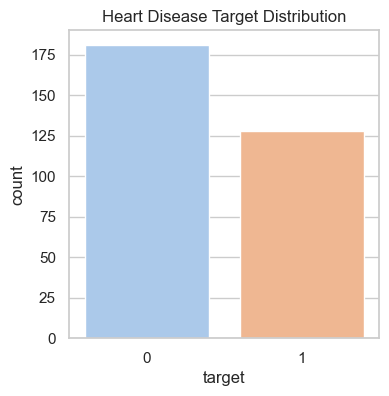

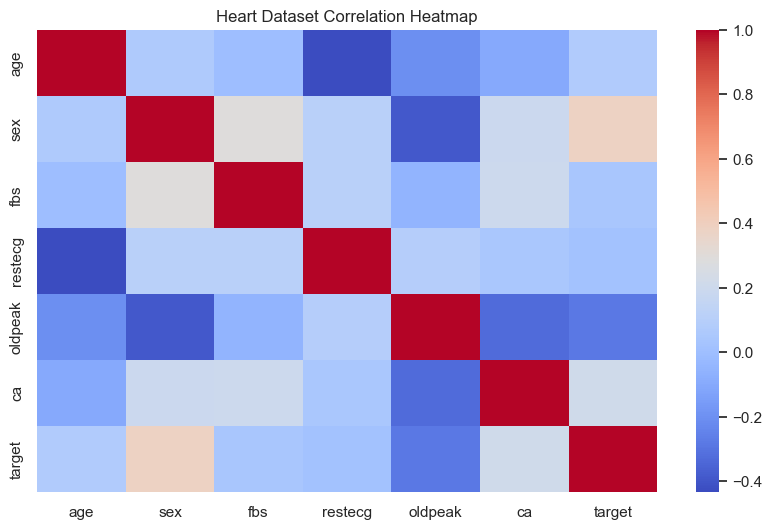


📊 DIABETES DATASET VISUALS


C:\Users\Kashif Mughal\AppData\Local\Temp\ipykernel_8240\821589779.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outcome", data=diabetes, palette="muted")


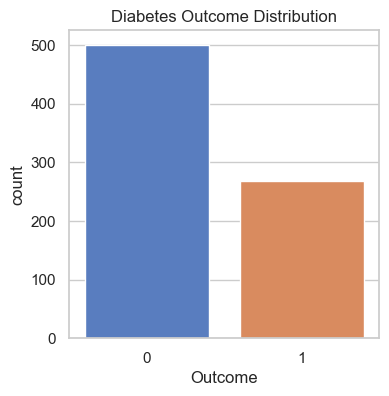

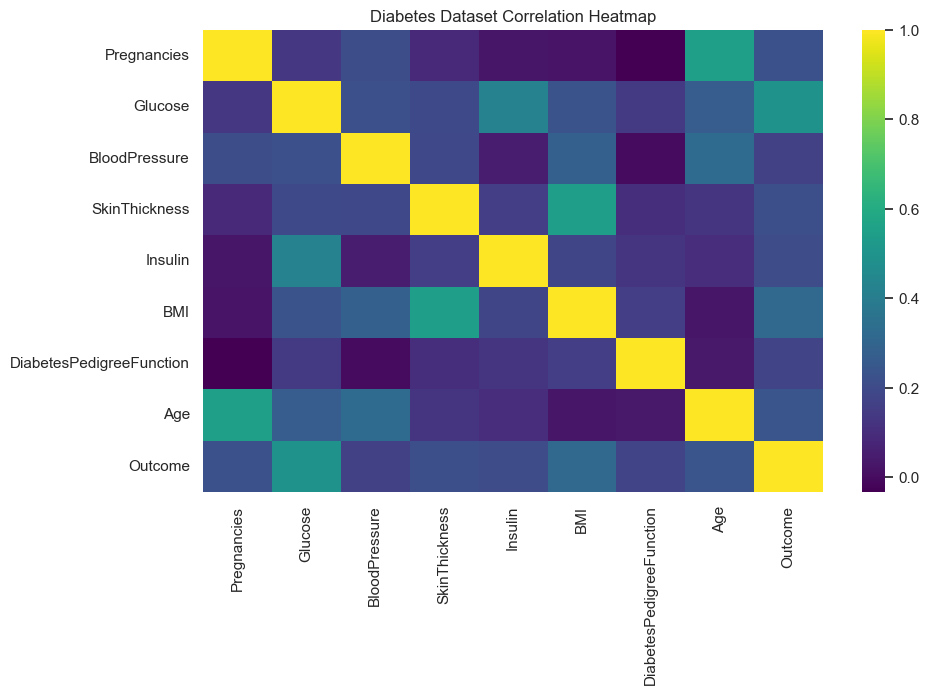

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# =========================
# HEART DATASET VISUALS
# =========================
print("📊 HEART DATASET VISUALS")

# Target balance
plt.figure(figsize=(4,4))
sns.countplot(x="target", data=heart, palette="pastel")
plt.title("Heart Disease Target Distribution")
plt.show()

# Correlation heatmap (numeric only)
plt.figure(figsize=(10,6))
sns.heatmap(heart.select_dtypes(include="number").corr(), annot=False, cmap="coolwarm")
plt.title("Heart Dataset Correlation Heatmap")
plt.show()


# =========================
# DIABETES DATASET VISUALS
# =========================
print("\n📊 DIABETES DATASET VISUALS")

# Outcome balance
plt.figure(figsize=(4,4))
sns.countplot(x="Outcome", data=diabetes, palette="muted")
plt.title("Diabetes Outcome Distribution")
plt.show()

# Correlation heatmap (numeric only)
plt.figure(figsize=(10,6))
sns.heatmap(diabetes.select_dtypes(include="number").corr(), annot=False, cmap="viridis")
plt.title("Diabetes Dataset Correlation Heatmap")
plt.show()

